# EOF Analysis of NEMO surface tracers

***

In [2]:
import numpy as np
import xarray as xr
import pymc3 as pm
from matplotlib import pyplot as plt, colors, dates
from datetime import datetime, timedelta
from scipy import signal, fft
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 12

***

## Load data

Functions

In [4]:
def calc_Cd(wspd):
    """Calculate the surface drag coefficient according to
    Hellerman and Rosenstein (1983) JPO, neglecting T effects
    """
    
    # Coefficients
    a_1 = 0.934e-3
    a_2 = 0.788e-4
    a_3 = 0.868e-4
    a_4 = -0.616e-6
    a_5 = -0.120e-5
    a_6 = -0.214e-5

    # Neglect temperature gradient
    Delta_T = 0

    # Calc C_d
    C_d = a_1 + a_2 * wspd + a_3 * Delta_T + a_4 * wspd**2 + a_5 * Delta_T**2 + a_6 * wspd * Delta_T
    
    return C_d

Parameters

In [5]:
# Subdomain
subdomain = [110, 370, 300, 850]

# Results path
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data'

# Load NEMO netCDF files (concatentated using NCO)
mask_NEMO = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)

# Slicing and indexing
skip = 5
loc = (0, 0, slice(*subdomain[2:], skip), slice(*subdomain[:2], skip))
tmask = mask_NEMO.tmask[loc].values.reshape(-1).astype(bool)
gridx, gridy = [var.reshape(-1)[tmask] for var in np.meshgrid(mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]])]

# Nitrate cutoff threshold
threshold, lag = 2, 5

# Air density
rho_a = 1.225

theta = np.deg2rad(55.5)

Load, reshape and filter results

In [6]:
data = {}

# Load GEM
with xr.open_dataset(f'{path}/HRDPS_1h_20141201_20200201_wind.nc') as ds:

    # Meshmask cut everything but open SoG
    landmask = ds.landmask.values
    landmask[:25, :] = 0   # San Juan Islands
    landmask[100:, :] = 0  # Discovery Islands
    landmask[:40, :50] = 0 # Left corner
    landmask[:40, 73:] = 0 # JdF/Gulf Islands
    landmask[40:, 61:] = 0 # Fraser River
    landmask[58:, 53:] = 0 # Howe Sound
    landmask[76:, 35:] = 0 # Jervis Inlet
    landmask = landmask.reshape(-1).astype('bool')

    # Load u and v wind components
    u, v = [ds[var].values.reshape(-1, len(landmask))[:, landmask] for var in ['u_wind', 'v_wind']]

# Process wind according to Hellerman and Rosenstein 1983, JPO
wspd = np.sqrt(u**2 + v**2)
v = v * np.cos(theta) - u * np.sin(theta)
tau = rho_a * calc_Cd(wspd) * v * wspd
data['wind'] = v.mean(axis=1)
data['tau'] = tau.mean(axis=1)

# Load NEMO
slc = slice(None, None, skip)
with xr.open_dataset(f'{path}/SalishSea_1h_20141201_20200201_grid_T.nc') as ds:
    data['time'] = ds.time_counter.values.astype('datetime64[s]').astype(datetime)
    for var in tqdm(['votemper', 'nitrate']):
        data[var] = ds[var].isel(y=slc, x=slc).values.reshape(-1, len(tmask))[:, tmask]

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# Seasonal indexing
nitrate_median = np.median(data['nitrate'], axis=1)
isegments, iseason = [], []
for year in range(2015, 2020):
    mask = (data['time'] < datetime(year, 1, 1)) | (data['time'] > datetime(year+1, 1, 1))
    bounds = np.ma.where(np.ma.masked_where(mask, nitrate_median) < threshold)[0][[0, -1]]
    bounds = [bound + lag * hour for bound, hour in zip(bounds, [24, -24])]
    isegments.append(bounds)
    iseason.append(np.arange(*bounds))
iseason = np.hstack(iseason)

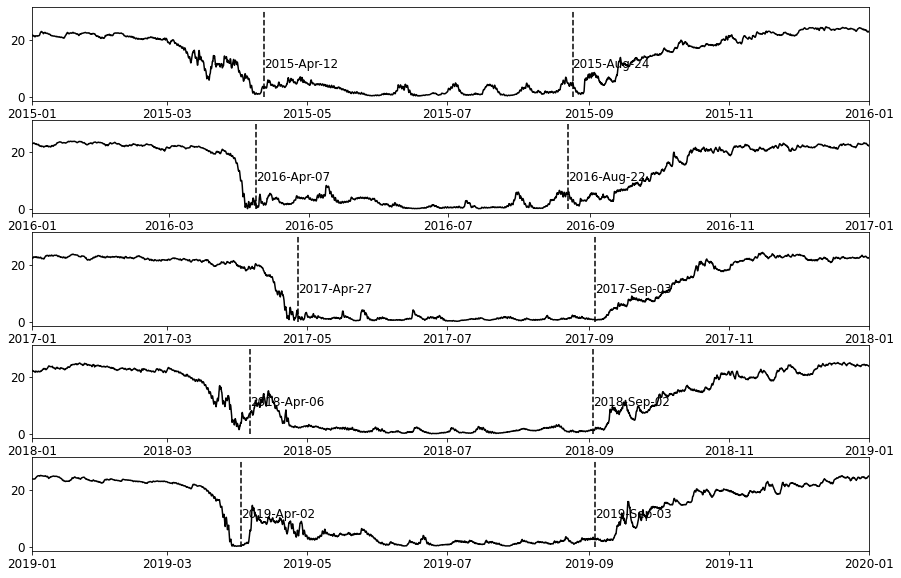

In [8]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10))
for ax, year, isegment in zip(axs, range(2015, 2020), isegments):
    ax.plot(data['time'], nitrate_median, 'k-')
    for i in isegment:
        ax.plot(np.repeat(data['time'][i], 2), [0, 30], 'k--')
        ax.text(data['time'][i], 10, data['time'][i].strftime('%Y-%b-%d'))
    ax.set_xlim([datetime(year, 1, 1), datetime(year+1, 1, 1)])

***

## Calculate EOFs

Functions

In [9]:
def varimax(A, maxiter=40, tol=1e-5):
    """Calculate the varimax rotation matrix H from the n x p PC loadings matrix A. H is determined
    iteratively from the Lagrange multiplier optimization of the varimax criterion.
    
    Adapted from:
    
    Horst, P. (1965) Factor Analysis of Data Matrices. Holt, Rinehart and Winston. New York, USA.
    Chapter 18: Analytical Rotations
        - Section 18.4: Simultaneous Factor Varimax Solution, Equations 18.4.1-10, pp. 428-429
        - Section 18.7: Mathematical Proofs, Equations 18.7.32-54, pp. 437-438
    
    The algorithm described in Section 18.4 has been reformulated to use SVD based on equivalent
    definitions for the rotation matrix described in Section 18.7. The eigenvalue matrix is used
    to evaluate convergence.
    
    This version of the varimax algorithm is functionally identical to those found in Sci-kit learn,
    Matlab, R, and presumably others.
    """
    
    # Initialization
    n, p = A.shape
    H = np.eye(p)
    d = 0
    
    # Iteration
    for i in tqdm(range(maxiter)):
        d_old = d
        B = A.dot(H)  # -------------------------------------------------------- 18.4.5
        beta = B * B * B - B.dot(np.diag(np.diag(B.T.dot(B)))) / n  # ---------- 18.4.6
        P, Delta, Q_T = np.linalg.svd(A.T.dot(beta))  # ------------------------ 18.7.42
        H = P.dot(Q_T)  # ------------------------------------------------------ 18.7.45
        d = sum(Delta)
        
        # Convergence
        if d_old != 0 and d/d_old < 1 + tol: break

    return H

In [10]:
def calc_EOF(z, rotate=True):
    """Calculate EOF matrices of n x p data matrix z using SVD
    and optional varimax rotation
    """
    
    # EOF dict
    EOF = {}
    
    # Calculate orthogonal EOF matrices
    A_prime, sqrtL, E_T = np.linalg.svd(z, full_matrices=False)
    EOF['A'] = A_prime.dot(np.diag(sqrtL))
    A2 = EOF['A'] * EOF['A']
    EOF['var'] = A2.sum(axis=0) / A2.sum()
    EOF['E'] = E_T.T
    
    # Calculate rotated matrices
    if rotate:

        # Get varimax rotation matrix
        R = varimax(EOF['A'])

        # Rotate matrices
        EOF['B'] = EOF['A'].dot(R)
        B2 = EOF['B'] * EOF['B']
        EOF['var_rot'] = B2.sum(axis=0) / B2.sum()
        EOF['U'] = EOF['E'].dot(R)
        
        # Sort rotated matrices
        isort = EOF['var_rot'].argsort()[::-1]
        EOF['var_rot'] = EOF['var_rot'][isort]
        EOF['B'] = EOF['B'][:, isort]
        EOF['U'] = EOF['U'][:, isort]
    
    return EOF

Calculate EOFs

In [11]:
# Calculate EOFs
window = np.blackman(1235)
EOF = {}
for key in ['votemper', 'nitrate']:
    z = np.array([col - np.convolve(col, window / sum(window), mode='same') for col in data[key].T]).T
    z = (z - z.mean(axis=0)[None, :])[iseason, :]
    EOF[key] = calc_EOF(z)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Save outputs as netCDF

In [290]:
# Save EOF results as netCDF
for var in ['votemper', 'nitrate']:
    coords = {'time': data['time'][iseason]}
    data_vars = {
        'gridx': ('space', gridx),
        'gridy': ('space', gridy),
        'A': (['time', 'modes'], EOF[var]['A']),
        'B': (['time', 'modes'], EOF[var]['B']),
        'E': (['space', 'modes'], EOF[var]['E']),
        'U': (['space', 'modes'], EOF[var]['U']),
        'var': ('modes', EOF[var]['var']),
        'var_rot': ('modes', EOF[var]['var_rot']),
    }

    fn = f'/ocean/bmoorema/research/MEOPAR/SoG_upwelling_EOF_paper/data/{var}_EOF.nc'
    xr.Dataset(data_vars=data_vars, coords=coords).to_netcdf(fn)

***

## Figures

### EOF spatial patterns

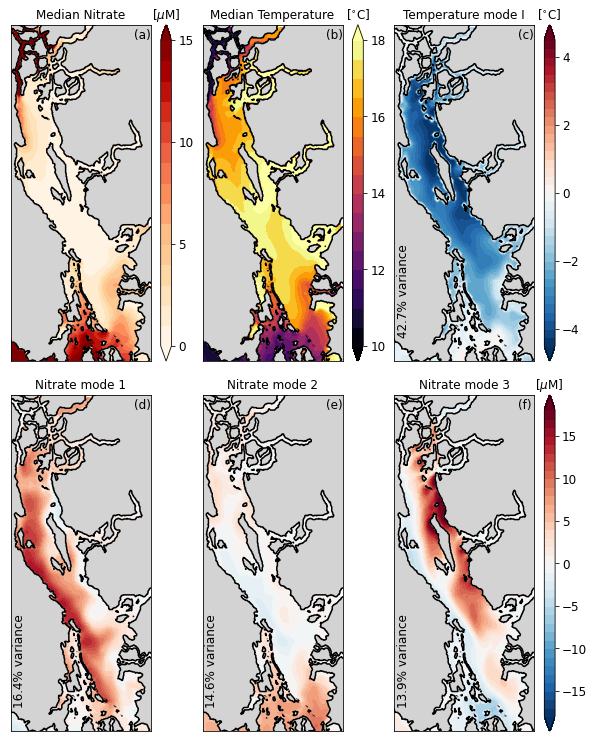

In [68]:
# Make figure and plotting params
fig, axs = plt.subplots(2, 3, figsize=(10, 13), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

# Loop through variables
k = 0

vardefs = [
    {'name': 'nitrate', 'label': 'Nitrate', 'units': '[$\mu$M]', 'cmap': 'OrRd', 'clim': (0, 15.1), 'interval': (1, 5)},
    {'name': 'votemper', 'label': 'Temperature', 'units': '[$^{\circ}$C]', 'cmap': 'inferno', 'clim': (10, 18.1), 'interval': (0.5, 2)},
]

# Plot median field
for ax, var in zip(axs[0, :2], vardefs):
    gridded = np.zeros(mask_NEMO.nav_lon.shape)
    for y, x, val in zip(gridy, gridx, np.median(data[var['name']][iseason, :], axis=0)): gridded[y, x] = val
    gridded = gridded[loc[2:]]
    c = ax.contourf(
        mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]], gridded,
        levels=np.arange(*var['clim'], var['interval'][0]), cmap=var['cmap'], extend='both',
    )
    ax.set_title(f"Median {var['label']}", fontsize=12)
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1-0.01, pos.y0, 0.015, pos.height])
    cbar = fig.colorbar(c, cax=cax, ticks=np.arange(*var['clim'], var['interval'][1]))
    for C in c.collections: C.set_edgecolor('face')
    cbar.ax.set_title(var['units'], fontsize=12)
    cbar.solids.set_edgecolor('face')

# Plot temperate mode I
norm = -np.percentile(abs(EOF['votemper']['B'][:, 0]), 99.9)
gridded = np.zeros(mask_NEMO.nav_lon.shape)
for y, x, val in zip(gridy, gridx, EOF['votemper']['U'][:, 0]): gridded[y, x] = val
gridded = gridded[loc[2:]]
c = axs[0, 2].contourf(
    mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]], gridded * norm,
    levels=np.arange(-4.5, 4.6, 0.25), cmap='RdBu_r', extend='both',
)
axs[0, 2].text(0.02, 0.08, f"{EOF['votemper']['var_rot'][0]*100:.01f}% variance", rotation=90, transform=axs[0, 2].transAxes)
axs[0, 2].set_title('Temperature mode I', fontsize=12)
pos = axs[0, 2].get_position()
cax = fig.add_axes([pos.x1-0.01, pos.y0, 0.015, pos.height])
cbar = fig.colorbar(c, cax=cax, ticks=range(-4, 5, 2))
for C in c.collections: C.set_edgecolor('face')
cbar.ax.set_title('[$^{\circ}$C]', fontsize=12)
cbar.solids.set_edgecolor('face')

# Plot nitrate modes
for ax, mode in zip(axs[1, :], range(3)):
    norm = np.percentile(abs(EOF['nitrate']['B'][:, mode]), 99.9)
    gridded = np.zeros(mask_NEMO.nav_lon.shape)
    for y, x, val in zip(gridy, gridx, EOF['nitrate']['U'][:, mode]): gridded[y, x] = val
    gridded = gridded[loc[2:]]
    c = ax.contourf(
        mask_NEMO.x[loc[3]], mask_NEMO.y[loc[2]], gridded * norm,
        levels=range(-18, 19), cmap='RdBu_r', extend='both',
    )
    ax.text(0.02, 0.08, f"{EOF['nitrate']['var_rot'][mode]*100:.01f}% variance", rotation=90, transform=ax.transAxes)
    ax.set_title(f"Nitrate mode {mode+1}", fontsize=12)
    for C in c.collections: C.set_edgecolor('face')

# Add nitrate colorbar
pos = axs[1, 2].get_position()
cax = fig.add_axes([pos.x1-0.01, pos.y0, 0.015, pos.height])
cbar = fig.colorbar(c, cax=cax, ticks=range(-15, 16, 5))
for C in c.collections: C.set_edgecolor('face')
cbar.ax.set_title('[$\mu$M]', fontsize=12)
cbar.solids.set_edgecolor('face')

# Formatting for all panels
for ax in axs.ravel():
    ax.contourf(mask_NEMO.x, mask_NEMO.y, mask_NEMO.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(mask_NEMO.x, mask_NEMO.y, mask_NEMO.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim(subdomain[:2])
    ax.set_ylim(subdomain[2:])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect(5/4.4)
    ax.text(0.88, 0.96, f'({chr(97+k)})', transform=ax.transAxes)
    k += 1
    
fig.savefig('/home/bmoorema/Desktop/revision_figs/EOF.pdf', bbox_inches='tight')

### Principle component time series

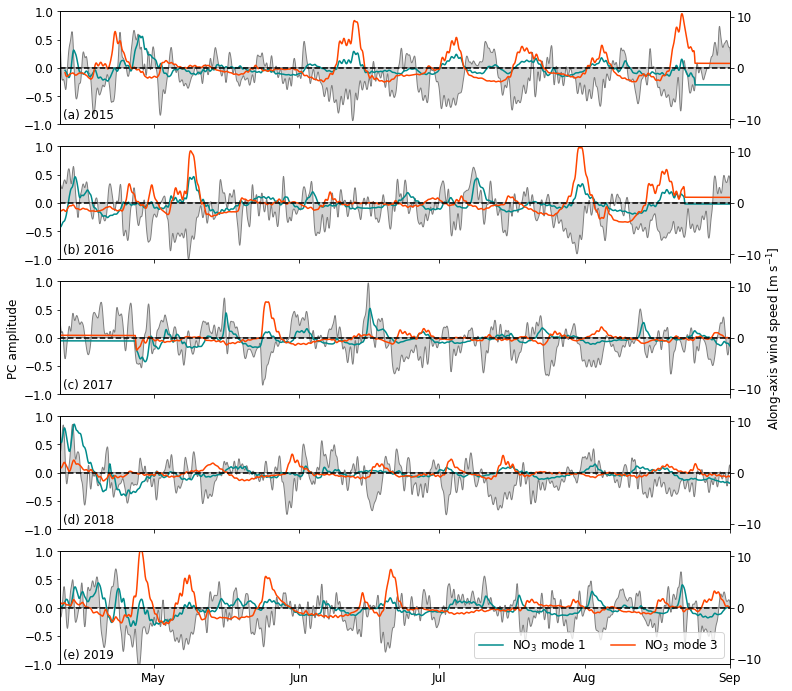

In [69]:
window = np.blackman(25)
fig, axs = plt.subplots(5, 1, figsize=(12, 12), gridspec_kw={'wspace': 0.05})
k = 0
l = []
for ax, year in zip(axs, range(2015, 2020)):
    
    xlim = [datetime(year, *md) for md in [(4, 11), (9, 1)]]
        
    # Set up axes
    ax.set_zorder(1)
    ax.patch.set_visible(False)
    ax2 = ax.twinx()
    ax2.set_ylim([-11, 11])
    ax.set_ylim([-1, 1])
    ax.set_xlim(xlim)
    if year == 2017:
        ax.set_ylabel('PC amplitude')
        ax2.set_ylabel('Along-axis wind speed [m s$^{-1}$]')

    # Plot wind
    wind = np.convolve(data['wind'], window / sum(window), mode='same')
    ax2.fill_between(data['time'], wind, facecolor='lightgray', edgecolor='gray', label='HRDPS')
    
    # Plot NO3 PCs
    for mode, color in zip([0, 2], ['darkcyan', 'orangered']):
        norm = np.percentile(abs(EOF['nitrate']['B'][:, mode]), 99.9)
        PC = np.convolve(EOF['nitrate']['B'][:, mode]/norm, window / sum(window), mode='same')
        ax.plot(data['time'][iseason], PC, '-', color=color, label=f'NO$_3$ mode {mode+1}')

    # Formatting
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    if year < 2019: ax.xaxis.set_ticklabels('')
    ax.plot(xlim, [0, 0], 'k--')
    ax.text(0.005, 0.05, f'({chr(97+k)}) {year}', transform=ax.transAxes)
    k += 1

axs[4].legend(loc=4, ncol=4)

fig.savefig('/home/bmoorema/Desktop/revision_figs/PC_timeseries.pdf', bbox_inches='tight')

***

### PC power spectra

Multitaper spectral analysis using the Slepian sequencies provided by `scipy.signal.windows.dpss`

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.dpss.html

Squared coherence is generally defined in terms of the auto-spectral and cross-spectral densities of $x$ and $y$ as

$$C_{xy} = \frac{|P_{xy}|^2}{P_{xx}P_{yy}}$$

Since the multitaper method is an ensemble method, we define the spectral densities as weighted sums across the ensemble members (or tapers).

$$
\begin{align}
P_{xx} & = \sum_{k=1}^K\mu_k|X_{k}|^2 \\
P_{yy} & = \sum_{k=1}^K\mu_k|Y_{k}|^2 \\
P_{xy} & = \sum_{k=1}^K\mu_kX_{k}Y^*_{k}
\end{align}
$$

The best citation for this definition is probably Percival and Walden 1993, *Cambridge University press*

https://doi.org/10.1017/CBO9780511622762

but it's briefly summarized here

http://www.spectraworks.com/Help/mtmtheory.html

In [29]:
def calc_spectra(y, x=None, p=1, fs=24):
    """Calculate either the autospectral density or the coherence
    depending on whether x is provided or not, using the multitaper
    method and DPSS windows
    """

    n, k = len(y), int(2 * p)
    nfft = 2**int(np.ceil(np.log2(n)))
    bw = fs / nfft
    freq = np.linspace(0, int(fs/2), int(nfft/2+1))
    tapers, weights = signal.windows.dpss(n, p, k, return_ratios=True)
    weights = weights[:, None]
    norm = np.percentile(abs(y), 99.9)
    #y = y / norm
    ffty = np.fft.rfft(tapers * (y - y.mean()), nfft)
    Pyy = np.sum(weights * abs(ffty)**2, axis=0)
    
    if x is None:
        return freq, Pyy / (Pyy.sum() * bw)
    else:
        x = x / np.percentile(abs(x), 99.9)
        fftx = np.fft.rfft(tapers * (x - x.mean()), nfft)
        Pxx = np.sum(weights * abs(fftx)**2, axis=0)
        Pxy = np.sum(weights * fftx * np.conj(ffty), axis=0)
        Cxy = abs(Pxy)**2 / (Pxx * Pyy)
        lag = abs(np.angle(Pxy) / freq / (2 * np.pi))
        return freq, Cxy, lag

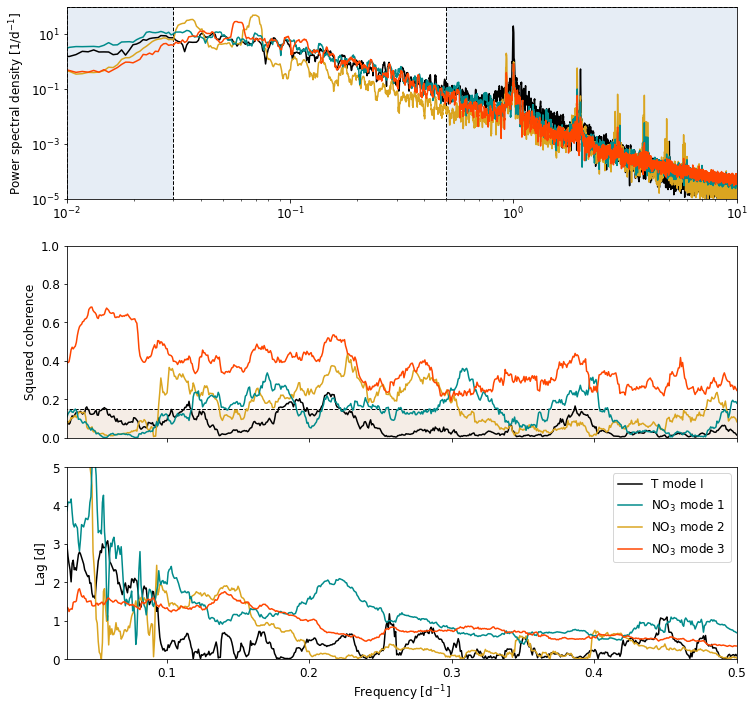

In [70]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(12, 12), gridspec_kw={'hspace': 0.2})
xlims = [(0.01, 10.0), (0.03, 0.5), (0.03, 0.5)]
ylims = [(0.00001, 100), (0, 1), (0, 5)]

# Shade frequencies outside coherence region
for x in np.array(xlims).T:
    axs[0].fill_betweenx(ylims[0], [x[0], x[0]], x[1], fc=[0.9, 0.93, 0.96], ec='k', ls='--', zorder=-1)

# Calculate 99% ci from white noise spectra and shade on plot
n, ci = len(iseason), []
for count in range(10):
    freq, Cxy, lag = calc_spectra(np.random.normal(0, 1, size=n), x=np.random.normal(0, 1, size=n), p=15)
    ci.append(Cxy)
ci = np.percentile(np.hstack(ci), 99)
axs[1].fill_between(freq[[0, -1]], [ci, ci], fc=[0.96, 0.93, 0.9], ec='k', ls='--', zorder=-1)

# Plot T mode
freq, PSD = calc_spectra(EOF['votemper']['B'][:, 0], p=2.5)
axs[0].plot(freq, PSD, color='k', zorder=0)
freq, Cxy, lag = calc_spectra(EOF['votemper']['B'][:, 0], x=data['tau'][iseason], p=15)
axs[1].plot(freq, Cxy, color='k', zorder=0)
axs[2].plot(freq, lag, color='k', zorder=0, label='T mode I')

# Plot NO3 modes
for mode, fac, color, zorder, ypos in zip(range(3), [1, -1, -1], ['darkcyan', 'goldenrod', 'orangered'], [1, 0, 2], [.8, .7, .6]):
    freq, PSD = calc_spectra(EOF['nitrate']['B'][:, mode], p=2.5)
    axs[0].plot(freq, PSD, color=color, zorder=zorder)
    freq, Cxy, lag = calc_spectra(fac*EOF['nitrate']['B'][:, mode], x=data['tau'][iseason], p=15)
    axs[1].plot(freq, Cxy, color=color, zorder=zorder)
    axs[2].plot(freq, lag, color=color, zorder=zorder, label=f"NO$_3$ mode {mode+1}")

# Formatting
ylabels = ['Power spectral density [1/d$^{-1}$]', 'Squared coherence', 'Lag [d]']
for ax, xlim, ylim, ylabel in zip(axs, xlims, ylims, ylabels):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
pos = axs[1].get_position()
axs[1].set_position([pos.x0, pos.y0-0.01, pos.width, pos.height])
axs[1].xaxis.set_ticklabels('')
axs[2].set_xlabel('Frequency [d$^{-1}$]')
axs[2].legend()

fig.savefig('/home/bmoorema/Desktop/revision_figs/PC_spectra.pdf', bbox_inches='tight')

***

### Linear regression

Here I'm using the Bayesian Markov Chain Monte Carlo (MCMC) package pyMC3 to perform the linear regression. A brief overview of the process is given in the following example

https://docs.pymc.io/pymc-examples/examples/generalized_linear_models/GLM-linear.html

Phil Austin's last PO seminar covered essentially the same material

https://github.com/phaustin/talks/blob/master/potalk/notebooks/potalk_rise.ipynb

**Correlation strength**

A "Bayesian" $R^2$ equivalent is defined as

$$R^2 = \frac{var(y_{pred})}{var(y_{pred}) + var(y_{res})}$$

This definition is consistent with the definition in the pyMC3 dependency ArviZ

https://github.com/arviz-devs/arviz/blob/main/arviz/stats/stats.py

**Significance testing**

There are Bayesian methods for comparing sample distributions ([T-test alternatives](https://docs.pymc.io/pymc-examples/examples/case_studies/BEST.html), [Bayes factors](https://docs.pymc.io/pymc-examples/examples/diagnostics_and_criticism/Bayes_factor.html)), however the philosophy of Bayesian inference seems to be moving away from these types of tests for regression applications. I'm not sure the exact path forward, but ideally we can just declare the correlation significant if zero is outside of the 99% confidence intervals of the slope distribution.

In [65]:
def backaverage(data, w):
    return np.hstack([[data[i-min(i, w+1):i].mean() for i in range(*segment)] for segment in isegments])


def linreg(x, y, samples=1000):

    with pm.Model() as model:
        sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
        intercept = pm.Normal("Intercept", 0, sigma=20)
        x_coeff = pm.Normal("x", 0, sigma=20)
        likelihood = pm.Normal("y", mu=intercept + x_coeff * x, sigma=sigma, observed=y)
        trace = pm.sample(samples, cores=2)

    x_mean = np.linspace(-0.2, 0.2, 100)
    coeffs = [trace['Intercept'].mean(), trace['x'].mean()]
    y_mean = coeffs[0] + coeffs[1] * x_mean
    y = np.vstack([trace[k]['Intercept'] + trace[k]['x'] * x_mean for k in np.random.randint(0, len(trace), samples)])
    y_01, y_99 = [np.percentile(y, p, axis=0) for p in (1, 99)]
    
    var_y = np.var(trace['Intercept'].mean() + trace['x'].mean() * x)
    r2 = var_y / (var_y + trace['sigma'].mean()**2)
    
    eq = f'y = {coeffs[1]:.1f}x - {abs(coeffs[0]):.1f}'
    
    return x_mean, y_mean, y_01, y_99, r2, eq

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8795574055697113, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8828657154690547, but should be close to 0.8. Try to increase the number of tuning steps.


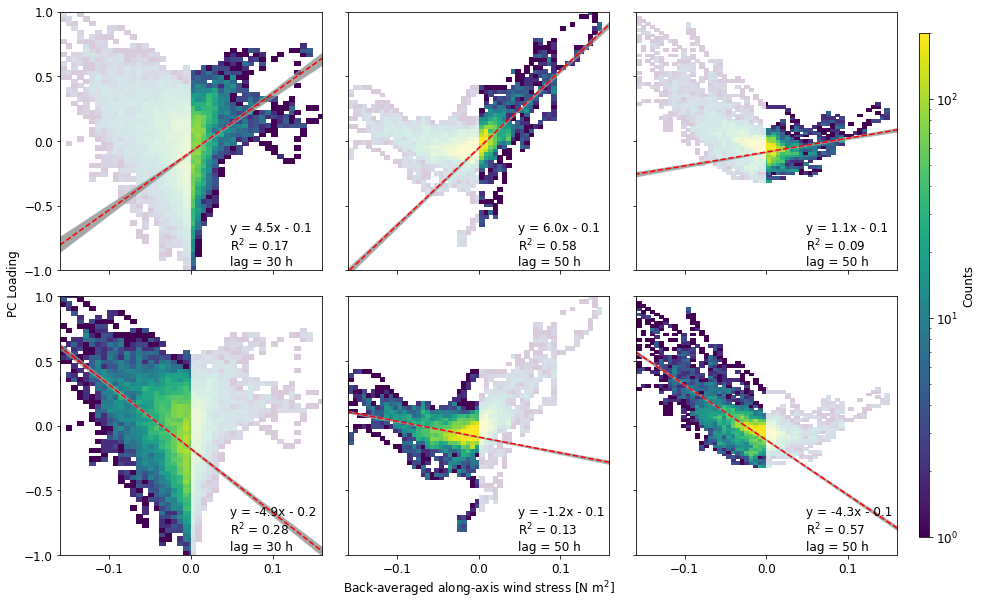

In [73]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})        
xlim, ylim = np.array([-0.16, 0.16]), [-1, 1]

w = {
    'votemper': {
        0: {'greater': 30, 'less': 30},
    },
    'nitrate': {
        0: {'greater': 50, 'less': 50},
        2: {'greater': 50, 'less': 50},
    },
}

for col, var, mode in zip(axs.T, ['votemper', 'nitrate', 'nitrate'], [0, 0, 2]):
    for ax, func in zip(col, ['greater', 'less']):
        norm = np.percentile(EOF[var]['B'][:, mode], 99.99)
        if var == 'votemper': norm = -norm
        B = EOF[var]['B'][:, mode] / norm
        tau = backaverage(data['tau'], w[var][mode][func])
        _, _, _, c = ax.hist2d(tau, B, bins=60, norm=colors.LogNorm(vmin=1, vmax=200))
        ax.fill_betweenx(ylim, np.repeat(xlim[~getattr(np, func)(xlim, 0)][0], 2), fc='w', alpha=0.8)
        
        index = getattr(np, func)(tau, 0)
        x_mean, y_mean, y_01, y_99, r2, eq = linreg(tau[index], B[index])
        ax.fill_between(x_mean, y_01, y_99, ec='darkgray', fc='gray', alpha=0.7)
        ax.plot(x_mean, y_mean, 'r--')
        ax.text(0.65, 0.02, f'{eq}\nR$^{2}$ = {r2:.2f}\nlag = {w[var][mode][func]} h', transform=ax.transAxes)
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_ticks([-0.1, 0, 0.1])
        ax.yaxis.set_ticks([-1, -0.5, 0, 0.5, 1])
        if func == 'greater': ax.xaxis.set_ticklabels('')
        if var == 'nitrate': ax.yaxis.set_ticklabels('')

axs[1, 1].set_xlabel('Back-averaged along-axis wind stress [N m$^{2}$]')
axs[1, 0].set_ylabel('PC Loading', y=1.05)
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='Counts')

fig.savefig('/home/bmoorema/Desktop/revision_figs/PC_correlation.pdf', bbox_inches='tight')